In [1]:
import os
import sys

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

import medmnist
from medmnist import INFO

import importlib
import moment_kernels as mk
importlib.reload(mk)

import torch
import torch.nn as tnn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.transforms.functional import rotate

import e2cnn.nn as enn
import e2cnn.gspaces as gspaces

from torcheval.metrics.functional import multiclass_confusion_matrix
import seaborn as sns
from torchmetrics.classification import ROC
from torchvision.transforms import RandomRotation

import tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json

# located in /rotnet/benchmark/benchmark_models.py
from benchmark.benchmark_models import *

## **Hyperparameters**

In [2]:
# hyperparameters
EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001
num_layers = 5

## **Dataset**

In [3]:
# NOTE: SET THESE ACCORDING TO THE DATASET AND TRAINING RUN YOU WANT TO USE (after training)
data_flag = 'bloodmnist'# 'bloodmnist'#"breastmnist" #"bloodmnist" #'organamnist' 'dermamnist', 'pathmnist', etc...
run = 0 # 1, etc...

download = False
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Transforms**

In [4]:
# transforms to convert from image to normalized tensor (or more if augmentation)
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

# separate transforms for test
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

## **Splitting and Shuffling**

In [5]:
train_dataset = DataClass(split = "train", transform = train_transforms, download = download)
valid_dataset = DataClass(split = "val", transform = test_transforms, download = download)
test_dataset = DataClass(split = "test", transform = test_transforms, download = download)

train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = data.DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## **Models**

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {
    'VanillaCNN' : {'model' : VanillaCNN(img_channels = n_channels, n0 = 32, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialECNN' : {'model' : TrivialECNN(img_channels = n_channels, n0 = 67, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialIrrepECNN' : {'model' : TrivialIrrepECNN(img_channels = n_channels, n0 = 62, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'RegularECNN' : {'model' : RegularECNN(img_channels = n_channels, n0 = 29, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialMoment' : {'model' : TrivialMoment(img_channels = n_channels, n0 = 55, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialIrrepMoment' : {'model' : TrivialIrrepMoment(img_channels = n_channels, n0 = 59, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
}

/nafs/dtward/intelpython3/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])


In [7]:
# add the metrics to the models dictionary
for model in models:
    models[model]['metrics'] = json.load(open(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"metrics_{model}_{data_flag}{run}.json"), "r"))
    models[model]['num_params'] = count_parameters(models[model]['model'])
    models[model]['n_channels'] = models[model]['model'].stages[1]
    models[model]['n_layers'] = models[model]['model'].num_layers

## **Visualization**

### **Parameters/Structure**

In [8]:
parameter_table = pd.DataFrame(columns = ['Model', 'Parameters', 'Channels', 'N Layers'])
for model_name, model_dict in models.items():
    model = model_dict['model']
    parameter_table.loc[len(parameter_table)] = [model_name, model_dict['num_params'], model_dict['n_channels'], model_dict['n_layers']]

parameter_table

,Model,Parameters,Channels,N Layers
0,VanillaCNN,1574664,32,5
1,TrivialECNN,1541477,67,5
2,TrivialIrrepECNN,1563214,62,5
3,RegularECNN,1500555,29,5
4,TrivialMoment,1555408,55,5
5,TrivialIrrepMoment,1566566,59,5


### **Loss**

In [9]:
plt.style.use('ggplot')

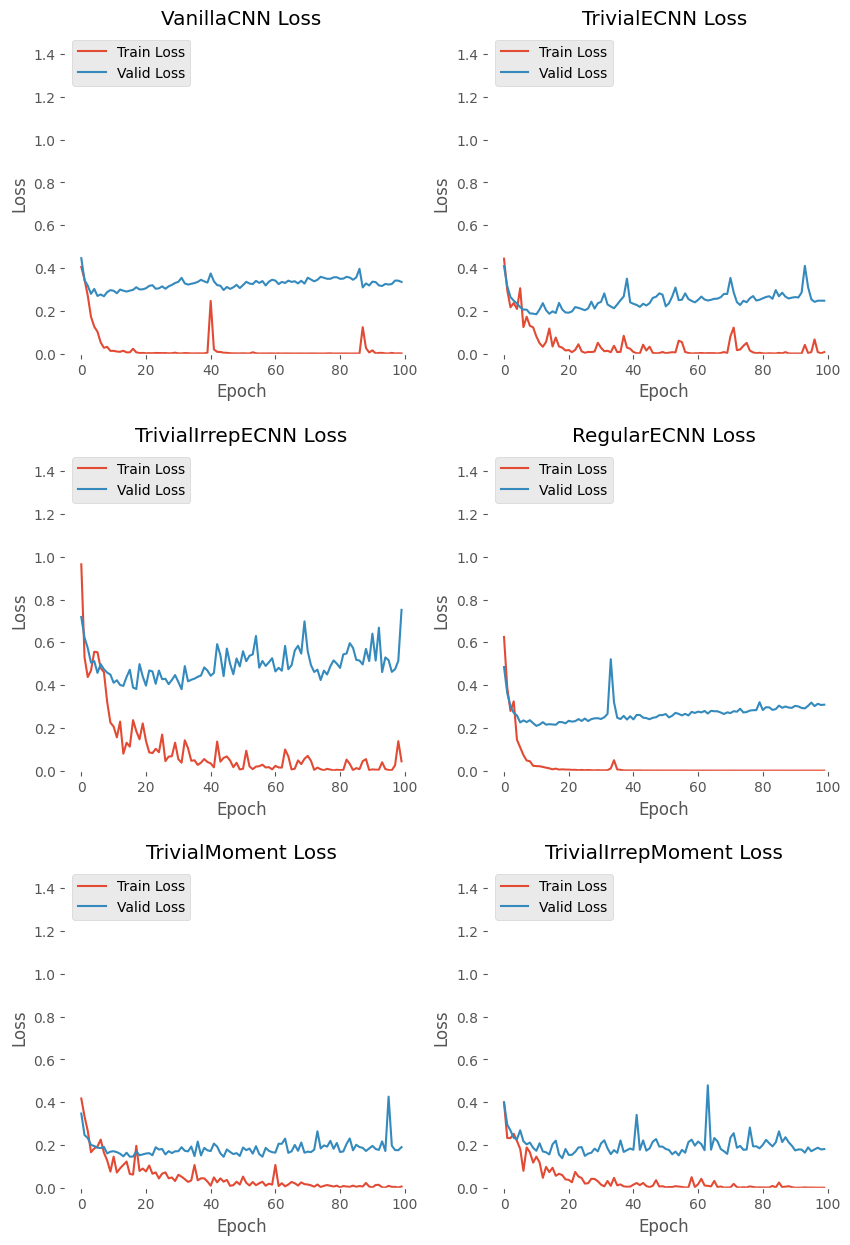

In [10]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (10, 15))
fig.subplots_adjust(hspace = 0.3)

for i, model in enumerate(models):
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(models[model]['metrics']['train_losses'], label = 'Train Loss')
    ax.plot(models[model]['metrics']['valid_losses'], label = 'Valid Loss')
    ax.set_title(f"{model} Loss")
    ax.set_ylim(0, 1.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.patch.set_facecolor('white') 
    ax.legend(loc='upper left')

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"loss.png"))
plt.show()

### **AUC/Acc**

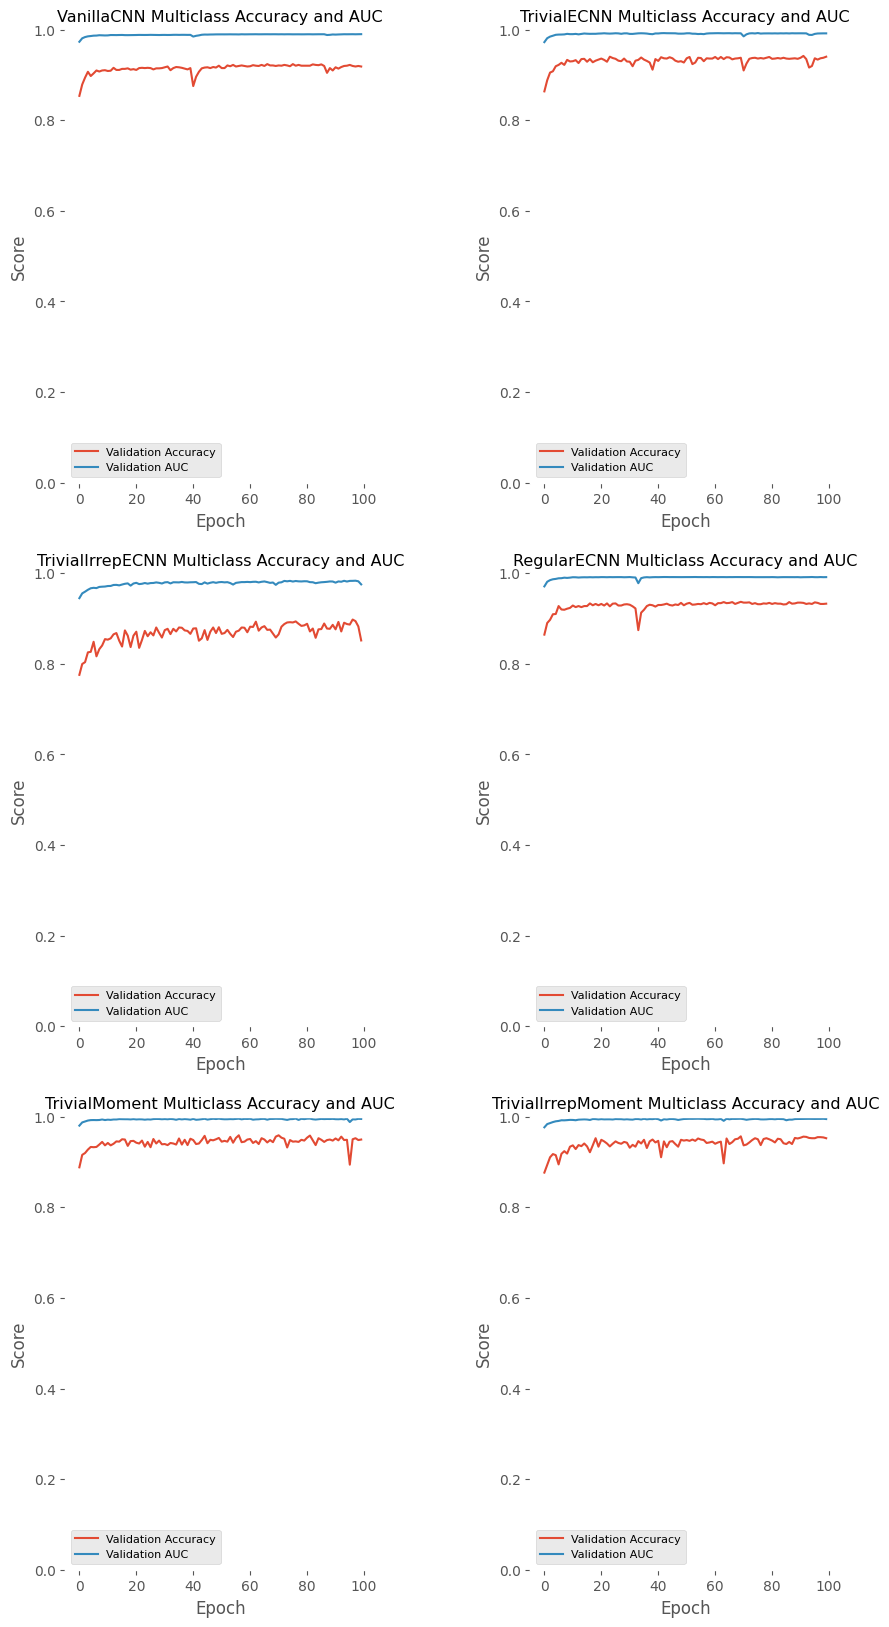

In [11]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (10, 20))
fig.subplots_adjust(hspace = 0.2, wspace = 0.5)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 8})

for i, model in enumerate(models):
    # Accuracy
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(models[model]['metrics']['valid_accuracies'], label = 'Validation Accuracy')

    # AUCROC
    ax.plot(models[model]['metrics']['valid_AUCROC'], label = 'Validation AUC')

    # other
    ax.set_title(f"{model} Multiclass Accuracy and AUC")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.patch.set_facecolor('white') 
    ax.set_ylim(0, 1)

    ax.legend(loc='lower left')

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"acc_AUC_epochs.png"))
plt.show()

### **Timing**

In [12]:
times_table = pd.DataFrame(columns = ['Model', 'Mean Epoch Time'])

for model_name, model_dict in models.items():
    model = model_dict['model']
    times_table.loc[len(times_table)] = [model_name, np.mean(model_dict['metrics']['epoch_times'])]

times_table

,Model,Mean Epoch Time
0,VanillaCNN,3.987863
1,TrivialECNN,7.903175
2,TrivialIrrepECNN,37.387504
3,RegularECNN,10.701813
4,TrivialMoment,7.782004
5,TrivialIrrepMoment,18.369628


### **Sample Confusion Matrix**

In [13]:
#'TrivialIrrepMoment', 'TrivialECNN', 'TrivialIrrepECNN', 'RegularECNN', 'VanillaCNN'
model_names = ['TrivialMoment', 'TrivialIrrepMoment', 'TrivialECNN', 'TrivialIrrepECNN', 'RegularECNN', 'VanillaCNN']
model_name = model_names[0]
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict = False)
model = model.eval()

In [14]:
targets = []
predictions = []

for i, sample_batch in enumerate(test_loader):
    sample_images = sample_batch[0].to(device)
    labels = sample_batch[1].to(device)

    prediction = model(sample_images)
    prediction = F.softmax(prediction, dim = 1)
    prediction = torch.argmax(prediction, dim = 1)

    targets.extend(labels.squeeze())
    predictions.extend(prediction)

targets = torch.stack(targets)
predictions = torch.stack(predictions)

cm = multiclass_confusion_matrix(targets, predictions, n_classes).cpu().numpy()

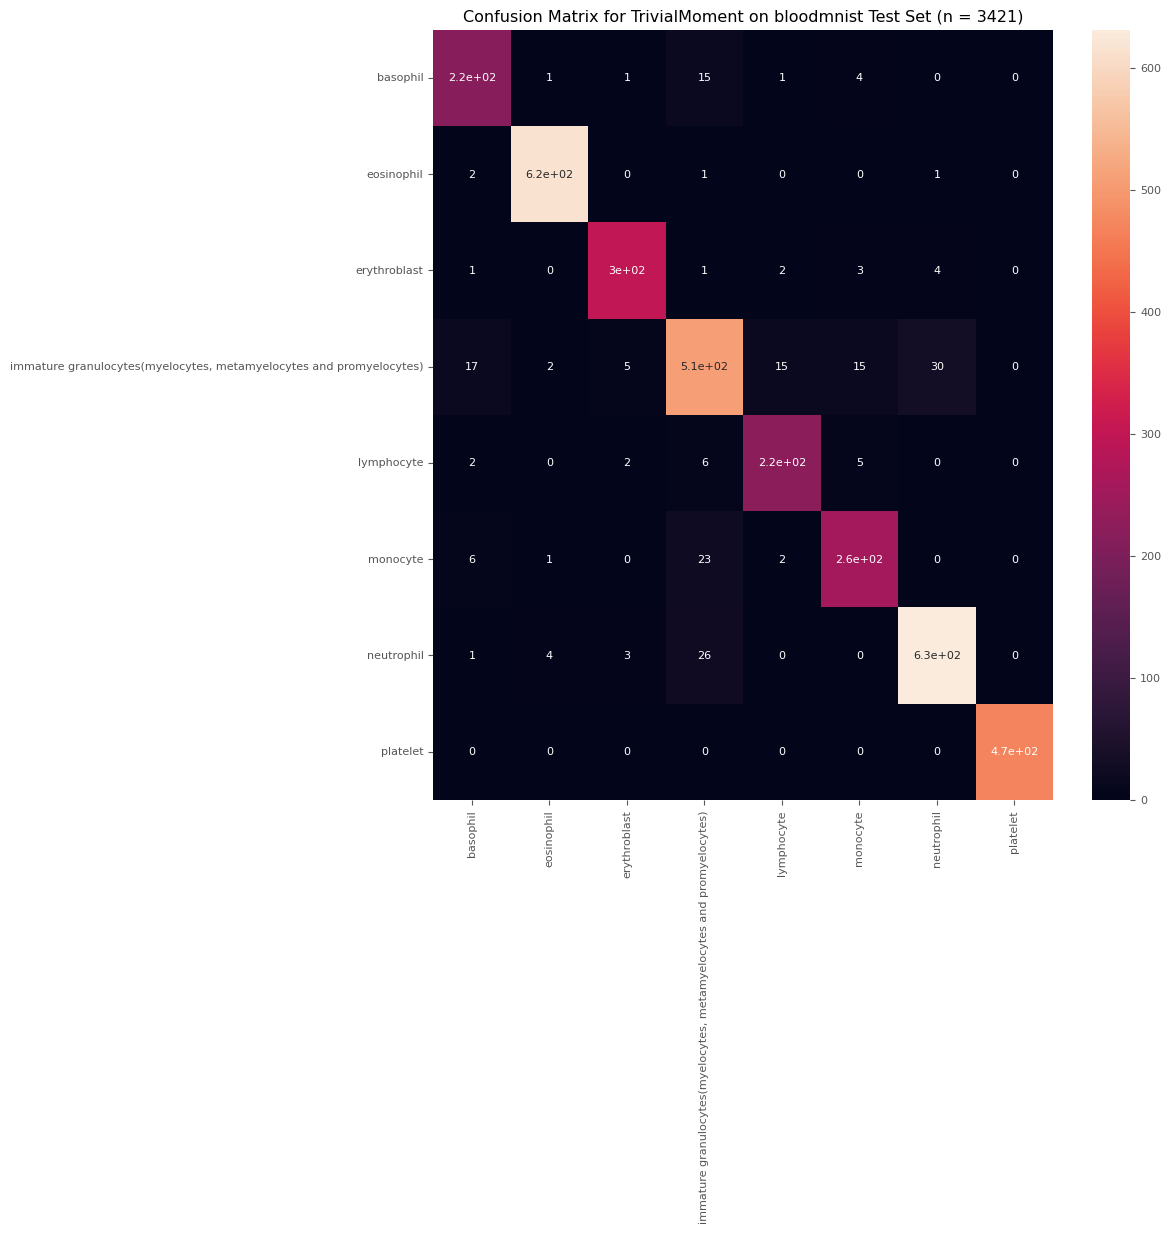

In [15]:
labels = info['label'].values()
plt.figure(figsize = (10, 10))
plt.title(f"Confusion Matrix for {model_name} on {data_flag} Test Set (n = {len(test_dataset)})")
sns.heatmap(cm, annot = True, xticklabels=labels, yticklabels=labels)

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

plt.savefig(os.path.join(fig_path, f"{model_name}_confusion_matrix.png"))
plt.show()

### **ROC**

In [16]:
targets = []
predictions = []

for i, sample_batch in enumerate(test_loader):
    sample_images = sample_batch[0].to(device)
    labels = sample_batch[1].to(device)

    prediction = model(sample_images)
    prediction = F.softmax(prediction, dim = 1)

    targets.extend(labels.squeeze())
    predictions.extend(prediction)

targets = torch.stack(targets)
predictions = torch.stack(predictions)

roc = ROC(task = 'multiclass', num_classes = n_classes)
roc.update(predictions, targets)

fpr, tpr, thresholds = roc.compute()

In [17]:
plt.style.use('ggplot')

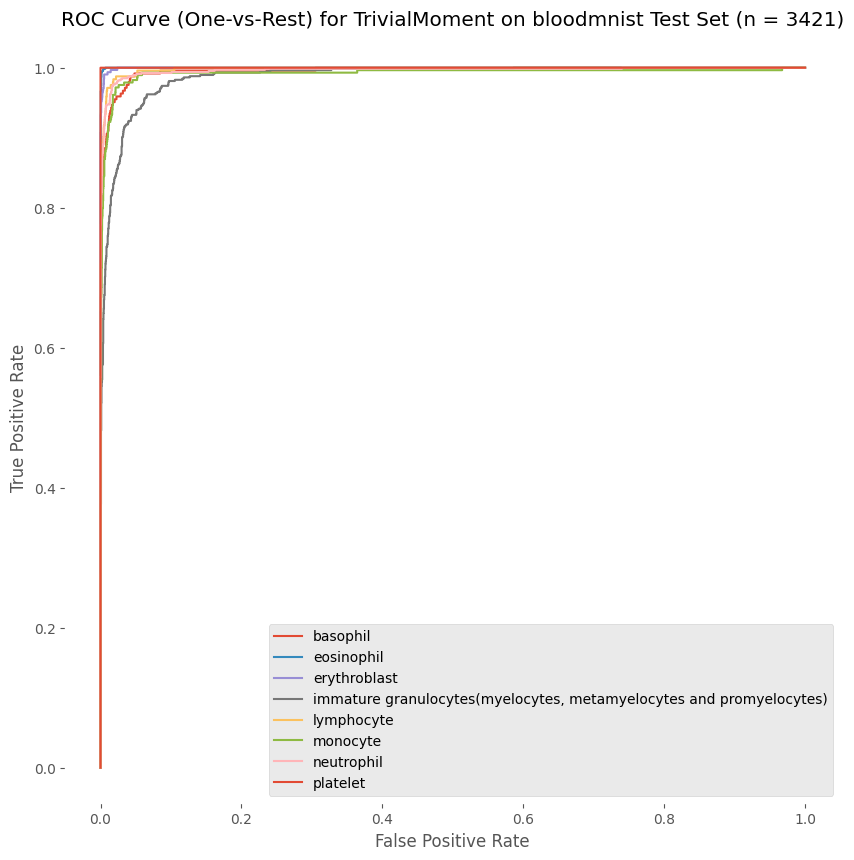

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(n_classes):
    ax.plot(fpr[i].cpu().numpy(), tpr[i].cpu().numpy(), label=f"{info['label'][str(i)]}")

ax.patch.set_facecolor('white')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.set_title(f"ROC Curve (One-vs-Rest) for {model_name} on {data_flag} Test Set (n = {len(test_dataset)})")

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

plt.savefig(os.path.join(fig_path, f"{model_name}_ROC.png"))
plt.show()

### **More Visualizations and Tables**

In [19]:
plt.style.use('ggplot')

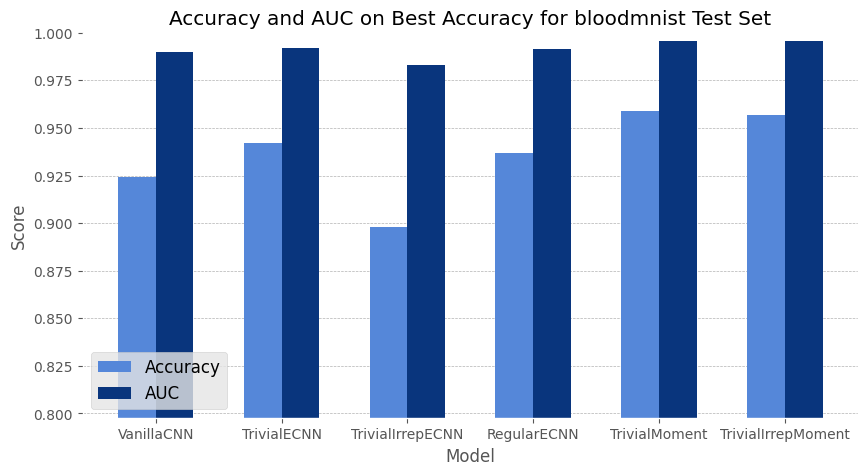

In [20]:
fig, ax = plt.subplots(figsize = (10, 5))
width = 0.3
xlabels = [name for name in models]
x = np.arange(6)

ax.bar(x, [models[name]['metrics']['best_acc'] for name in models], width, label = 'Accuracy', color = '#5587d9')
ax.bar(x + width, [models[name]['metrics']['auc_on_best_acc'] for name in models], width, label = 'AUC', color = '#09357d')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(xlabels)
ax.legend(loc='lower left', prop={'size': 12})
ax.patch.set_facecolor('white')
ax.set_title(f"Accuracy and AUC on Best Accuracy for {data_flag} Test Set")
ax.set_ylim(min([models[name]['metrics']['best_acc'] for name in models]) - 0.1, 1)
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"best_acc_AUC.png"))
plt.show()

In [21]:
metrics_table = pd.DataFrame(columns = ['Model', 'Best Accuracy', 'Best AUC', '# Parameters', '# Layers'])

for model_name, model_dict in models.items():
    model = model_dict['model']
    metrics_table.loc[len(metrics_table)] = [model_name, round(model_dict['metrics']['best_acc'], 3), round(model_dict['metrics']['auc_on_best_acc'], 3), model_dict['num_params'], model_dict['n_layers']]

metrics_table.index = ['' for _ in range(len(metrics_table))]
metrics_table

,Model,Best Accuracy,Best AUC,# Parameters,# Layers
,VanillaCNN,0.924,0.990,1574664,5
,TrivialECNN,0.942,0.992,1541477,5
,TrivialIrrepECNN,0.898,0.983,1563214,5
,RegularECNN,0.937,0.992,1500555,5
,TrivialMoment,0.959,0.996,1555408,5
,TrivialIrrepMoment,0.957,0.996,1566566,5


In [22]:
# save the frame
frame_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")

if not os.path.exists(frame_path):
    os.makedirs(frame_path)
md_frame = metrics_table.to_markdown()

with open(os.path.join(frame_path, f"run{run}_metrics.md"), "w") as f:
    f.write(md_frame)

### **Feature Map Testing Stuff**

In [23]:
model_name = 'TrivialMoment'
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict = False)
model.to(device)
model.eval()

intermediate_output = {}
def make_hook(key):
    def hook(module, input, output):
        intermediate_output[key] = output.detach().cpu().numpy()
    return hook

hooks = []
for name, module in model.named_modules():
    if model_name == 'TrivialIrrepMoment':
        if type(module) == mk.ScalarVectorToScalarVector:
            hooks.append(module.register_forward_hook(make_hook(name)))
    if model_name == 'TrivialMoment':
        if type(module) == mk.ScalarToScalar:
            hooks.append(module.register_forward_hook(make_hook(name)))
    if model_name == 'VanillaCNN':
        if type(module) == tnn.Conv2d:
            hooks.append(module.register_forward_hook(make_hook(name)))

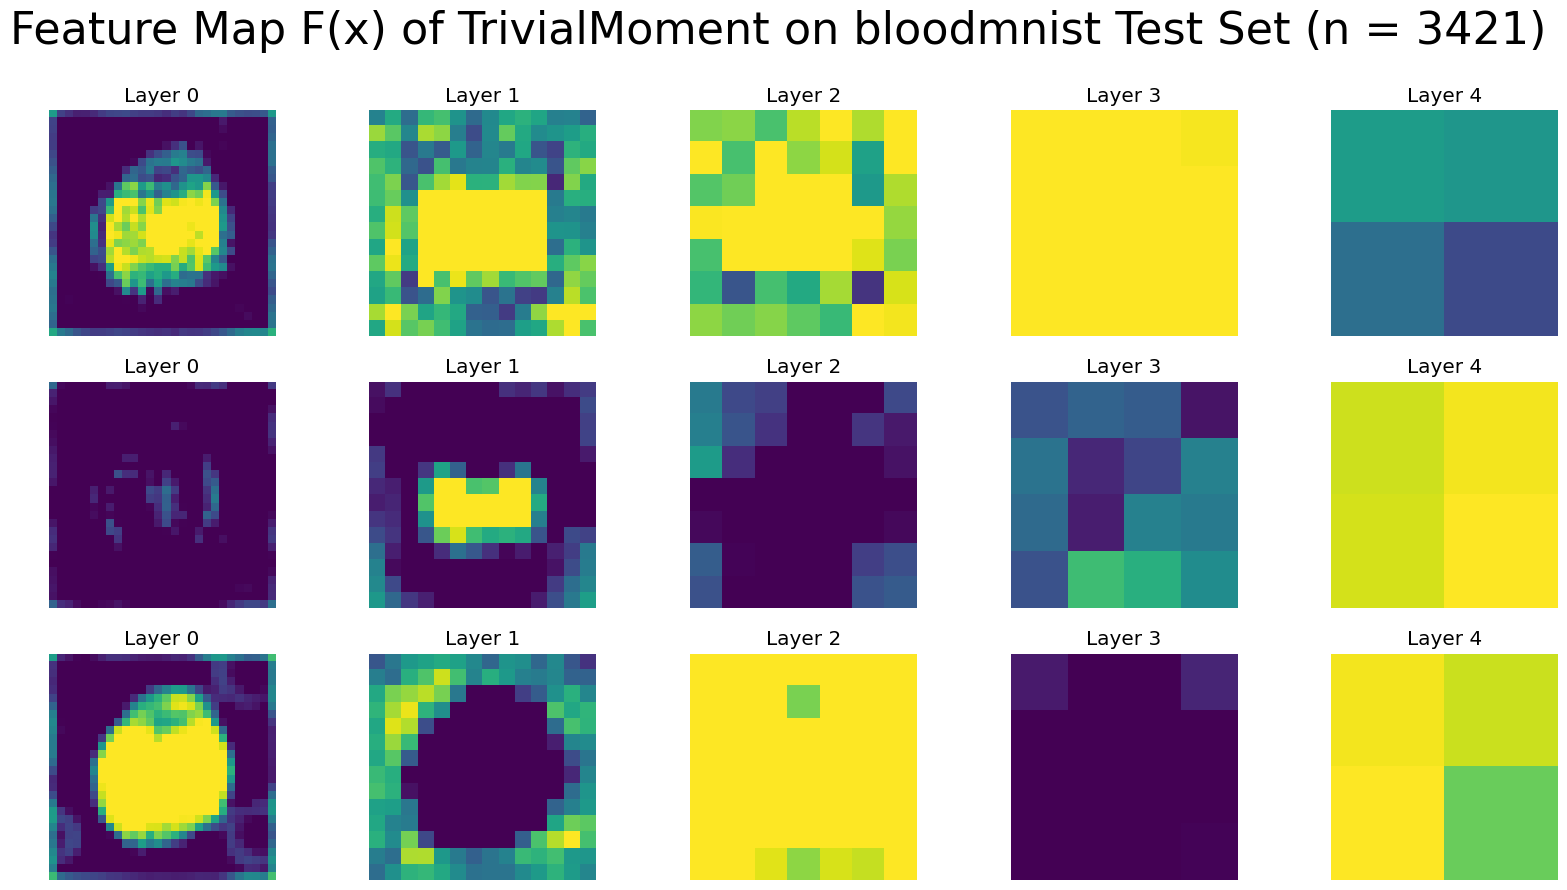

In [24]:
sample_batch = next(iter(test_loader))
sample_images = sample_batch[0].to(device)
image0 = sample_images[0].to(device)
image0 = image0.unsqueeze(0)

model(image0)
copy_intermediate_output0 = intermediate_output.copy()

n_layers = len(intermediate_output)
fig, axes = plt.subplots(3, n_layers, figsize = (20, 10))
fig.suptitle(f"Feature Map F(x) of {model_name} on {data_flag} Test Set (n = {len(test_dataset)})", fontsize = 32)
for ax in axes.flatten():
    ax.axis('off')
for i, (name, output) in enumerate(intermediate_output.items()):
    for j in range(3): # first 3 channels as an example
        img = output[0, j]
        axes[j, i].imshow(img, vmin=-1, vmax=1)
        axes[j, i].set_title(f"Layer {i}")

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(os.path.join(fig_path, f"{model_name}_feature_maps.png"))

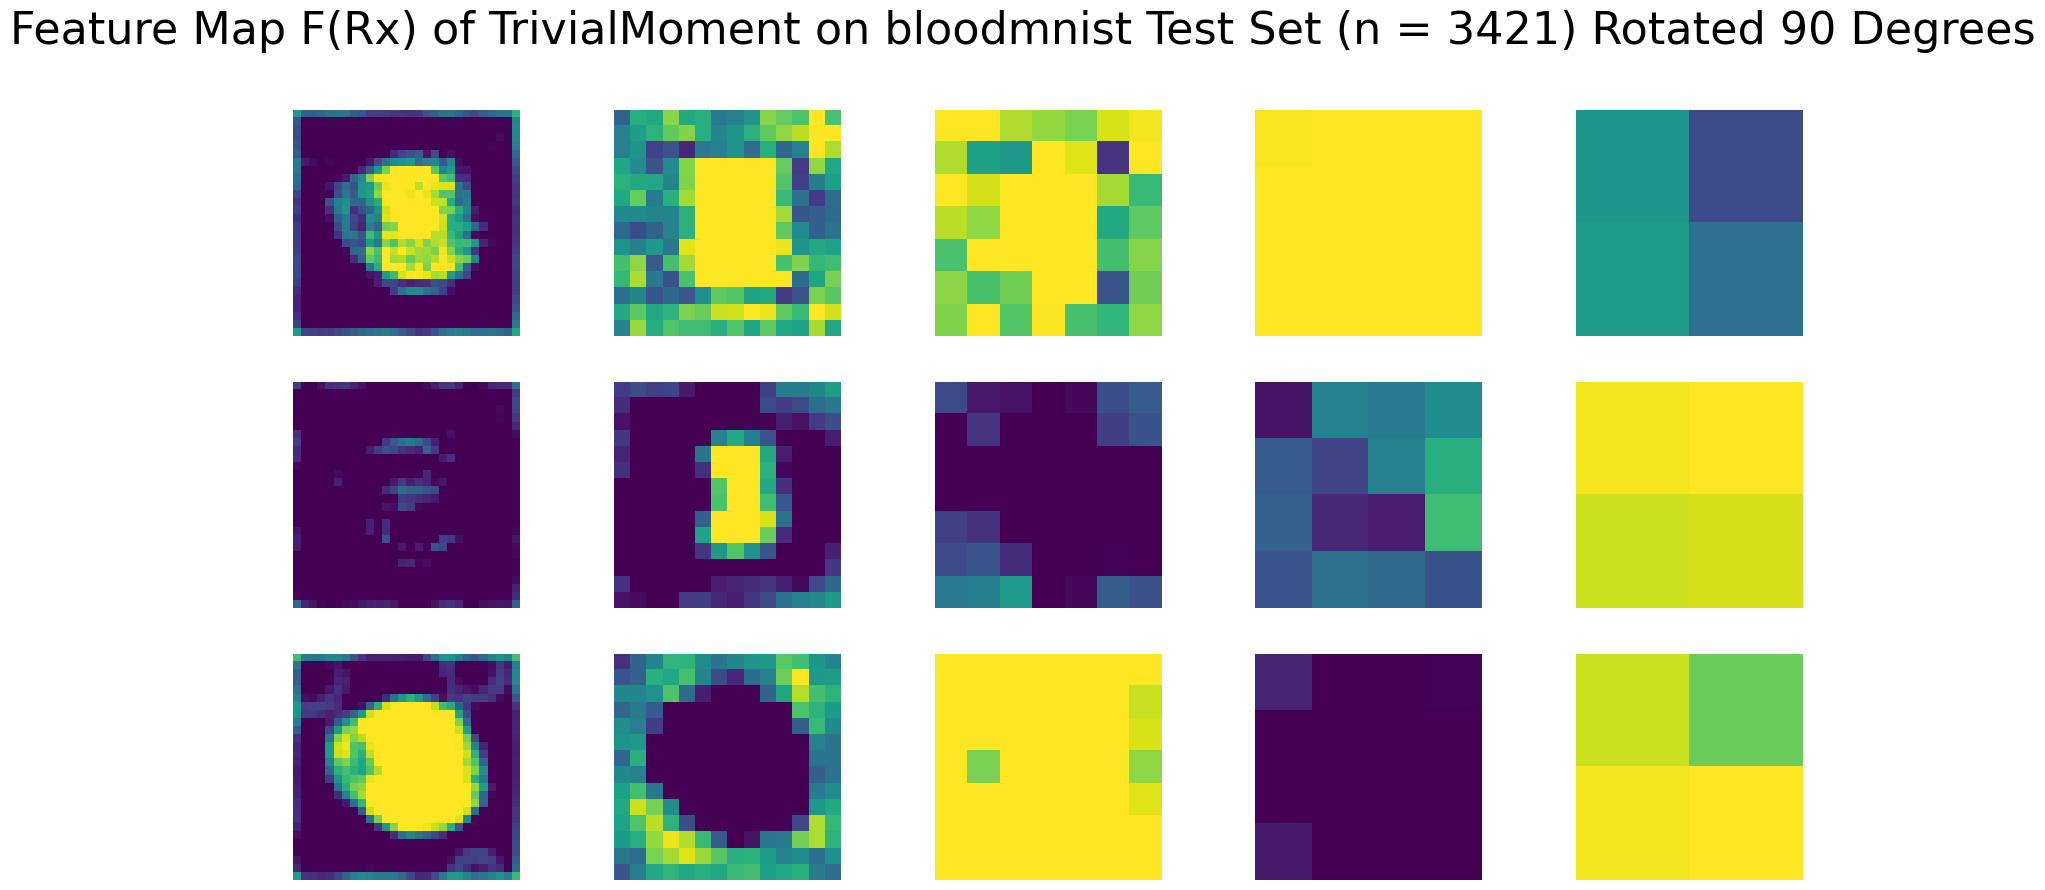

In [25]:
image90 = rotate(image0, 90)

intermediate_output = {}
model(image90)

#save for later
copy_intermediate_output90 = intermediate_output.copy()

n_layers = len(intermediate_output)
fig, axes = plt.subplots(3, n_layers, figsize = (20, 10))
fig.suptitle(f"Feature Map F(Rx) of {model_name} on {data_flag} Test Set (n = {len(test_dataset)}) Rotated 90 Degrees", fontsize = 32)
for ax in axes.flatten():
    ax.axis('off')

for i, (name, output) in enumerate(intermediate_output.items()):
    for j in range(3): # first 3 channels as an example
        img = output[0, j]
        axes[j, i].imshow(img, vmin=-1, vmax=1)

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(os.path.join(fig_path, f"{model_name}_feature_maps_rotated.png"))

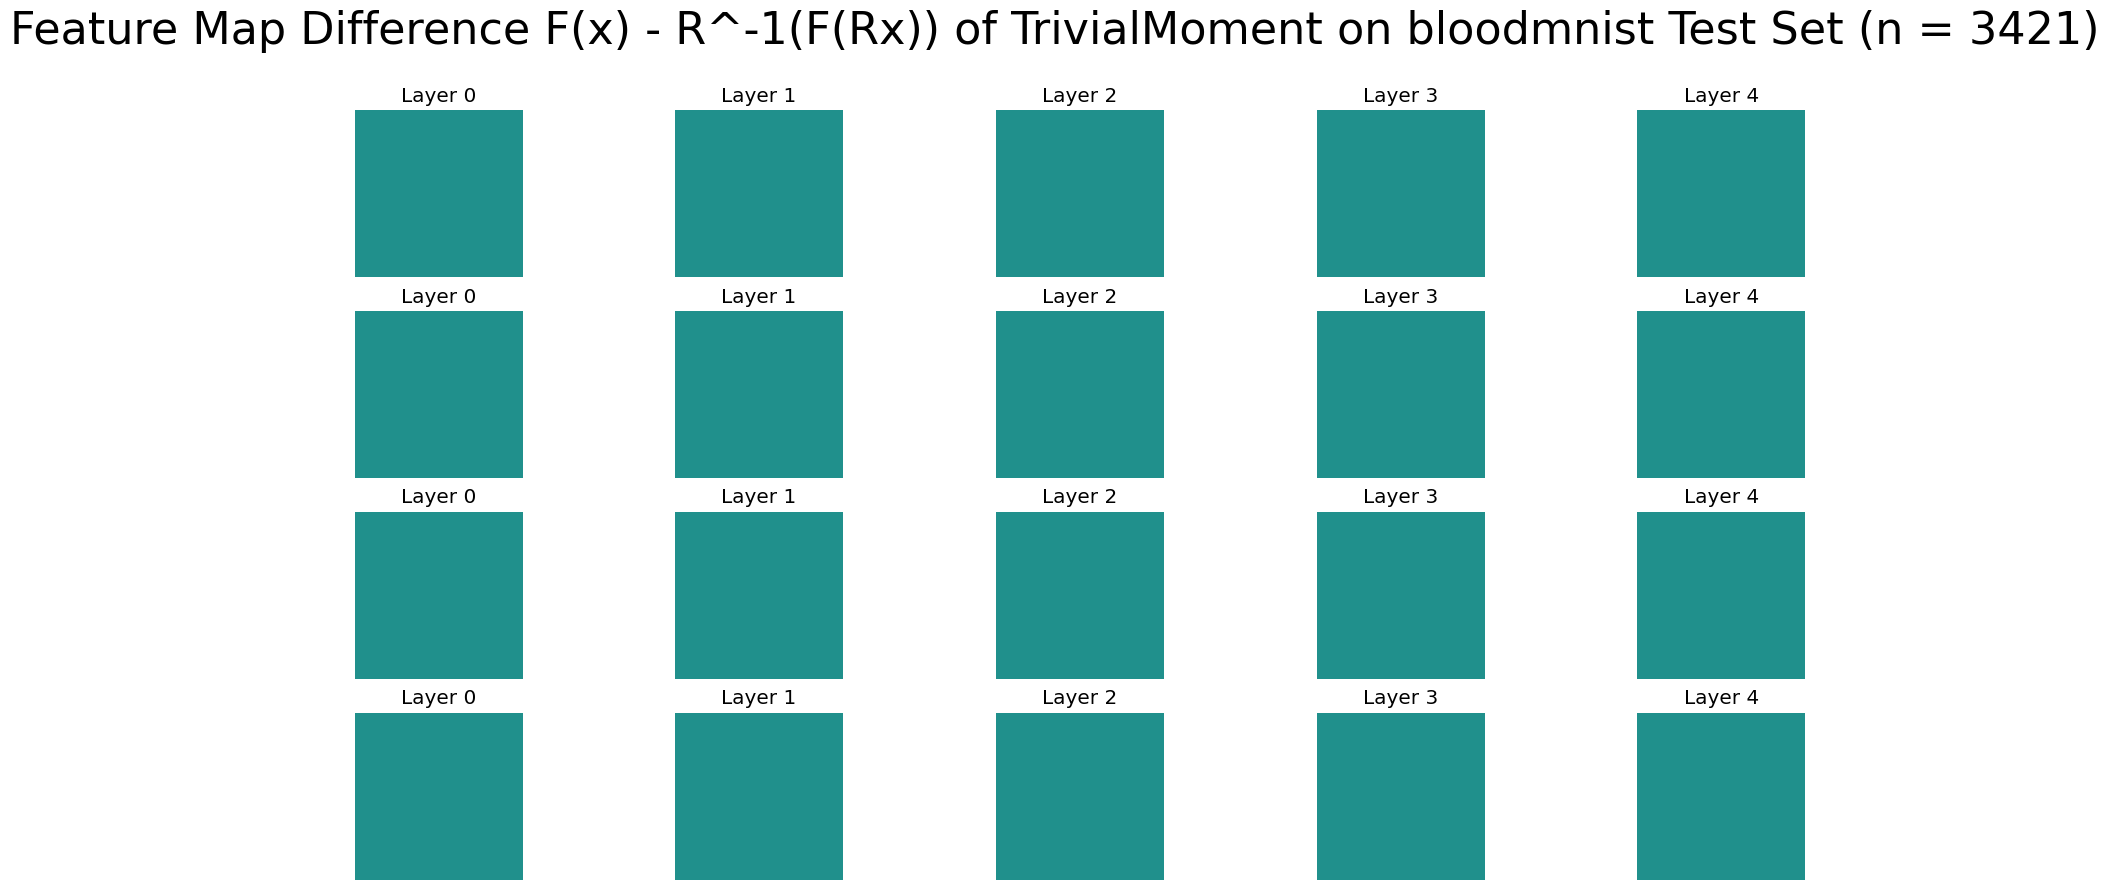

In [26]:
act_layer_names0 = [key for key in copy_intermediate_output0.keys()]
act_layer_name90 = [key for key in copy_intermediate_output90.keys()]

act_layer_output0 = [value for value in copy_intermediate_output0.values()]
act_layer_output90 = [np.rot90(value, k = -1, axes = (2, 3)) for value in copy_intermediate_output90.values()]
     
# calculate the difference between the two: f(t(x)) - t(f(x))
diff = [np.abs(act_layer_output0[i] - act_layer_output90[i]) for i in range(len(act_layer_output0))]

n_layers = len(act_layer_output0)
fig, axes = plt.subplots(4, n_layers, figsize = (20, 10))
fig.suptitle(f"Feature Map Difference F(x) - R^-1(F(Rx)) of {model_name} on {data_flag} Test Set (n = {len(test_dataset)})", fontsize = 32)
for ax in axes.flatten():
    ax.axis('off')

for i, output in enumerate(diff):
    for j in range(4): # first 3 channels as an example
        img = output[0, j]
        axes[j, i].imshow(img, vmin = -1, vmax = 1)
        axes[j, i].set_title(f"Layer {i}")

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(os.path.join(fig_path, f"{model_name}_feature_maps_diff.png"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..1.0].


neutrophil


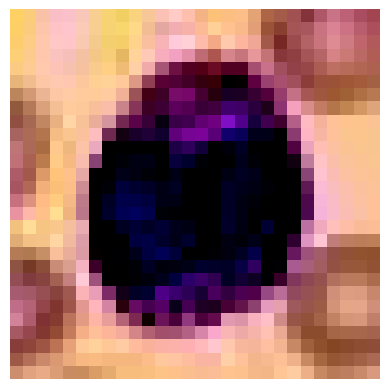

In [27]:
#plot original image as rgb
plt.imshow(sample_images[0].permute(1,2,0).cpu().numpy())
plt.axis('off')
print(info['label'][str(labels[0].tolist()[0])])

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
plt.savefig(os.path.join(fig_path, f"{model_name}_original_image.png"))

### **Rotational Equivariance on Cropped Data**

In [66]:
data_flag = 'retinamnist'
run = 1

download = False
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
# transforms to convert from image to normalized tensor (or more if augmentation, but not for testing purposes)
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    CircleCrop(28, 28, radius = 14, center = (13.5, 13.5)),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

# separate transforms for test
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    CircleCrop(28, 28, radius = 14, center = (13.5, 13.5)),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

train_dataset = DataClass(split = "train", transform = train_transforms, download = download)
valid_dataset = DataClass(split = "val", transform = test_transforms, download = download)
test_dataset = DataClass(split = "test", transform = test_transforms, download = download)

train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = data.DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [68]:
model_name = 'TrivialMoment'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {
    'VanillaCNN' : {'model' : VanillaCNN(img_channels = n_channels, n0 = 32, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialECNN' : {'model' : TrivialECNN(img_channels = n_channels, n0 = 67, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialIrrepECNN' : {'model' : TrivialIrrepECNN(img_channels = n_channels, n0 = 62, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'RegularECNN' : {'model' : RegularECNN(img_channels = n_channels, n0 = 29, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialMoment' : {'model' : TrivialMoment(img_channels = n_channels, n0 = 55, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
    'TrivialIrrepMoment' : {'model' : TrivialIrrepMoment(img_channels = n_channels, n0 = 59, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers)},
}

torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])


In [69]:
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict = False)

reference_model = models['VanillaCNN']['model']
reference_model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_VanillaCNN_{data_flag}{run}.pt")), strict = False)

<All keys matched successfully>

In [70]:
model.eval()
reference_model.eval()
with torch.no_grad():
    nangles = 36
    angles = np.arange(nangles)/nangles*360
    accuracysave = []
    accuracysave_ = []
    aucsave_ = []
    auc1save_ = []

    for angle in angles:
        ltrue = []
        ltrue_ = []
        lpred = []
        lpred_ = []
        for i, sample_batch in enumerate(test_loader):
            sample_images = sample_batch[0].to(device)
            labels = sample_batch[1].to(device).squeeze()
            x_rot = rotate(sample_images, angle)
            prediction = model(x_rot)
            prediction_ = reference_model(x_rot)
            prediction = F.softmax(prediction, dim = 1)
            prediction = torch.argmax(prediction, dim = 1)
            prediction_ = F.softmax(prediction_, dim = 1)
            prediction_ = torch.argmax(prediction_, dim = 1)
            ltrue.extend(labels.cpu().numpy())
            ltrue_.extend(labels.cpu().numpy())
            lpred.extend(prediction.cpu().numpy())
            lpred_.extend(prediction_.cpu().numpy())

        print(f"accuracy: {np.mean(np.array(ltrue) == np.array(lpred))}")
        print(f"accuracy_: {np.mean(np.array(ltrue_) == np.array(lpred_))}")
        accuracy = np.mean(np.array(ltrue) == np.array(lpred))
        accuracy_ = np.mean(np.array(ltrue_) == np.array(lpred_))
        accuracysave.append(accuracy)
        accuracysave_.append(accuracy_)

accuracy: 0.51
accuracy_: 0.4825
accuracy: 0.52
accuracy_: 0.54
accuracy: 0.515
accuracy_: 0.4875
accuracy: 0.505
accuracy_: 0.485
accuracy: 0.4825
accuracy_: 0.475
accuracy: 0.485
accuracy_: 0.485
accuracy: 0.5025
accuracy_: 0.47
accuracy: 0.5175
accuracy_: 0.4775
accuracy: 0.52
accuracy_: 0.4775
accuracy: 0.51
accuracy_: 0.505
accuracy: 0.52
accuracy_: 0.485
accuracy: 0.515
accuracy_: 0.4725
accuracy: 0.505
accuracy_: 0.4975
accuracy: 0.4825
accuracy_: 0.4775
accuracy: 0.485
accuracy_: 0.5
accuracy: 0.5025
accuracy_: 0.46
accuracy: 0.5175
accuracy_: 0.47
accuracy: 0.52
accuracy_: 0.49
accuracy: 0.51
accuracy_: 0.5
accuracy: 0.52
accuracy_: 0.475
accuracy: 0.515
accuracy_: 0.455
accuracy: 0.505
accuracy_: 0.4875
accuracy: 0.4825
accuracy_: 0.46
accuracy: 0.485
accuracy_: 0.4875
accuracy: 0.5025
accuracy_: 0.4475
accuracy: 0.5175
accuracy_: 0.5025
accuracy: 0.52
accuracy_: 0.505
accuracy: 0.51
accuracy_: 0.4975
accuracy: 0.52
accuracy_: 0.4775
accuracy: 0.515
accuracy_: 0.4825
accuracy

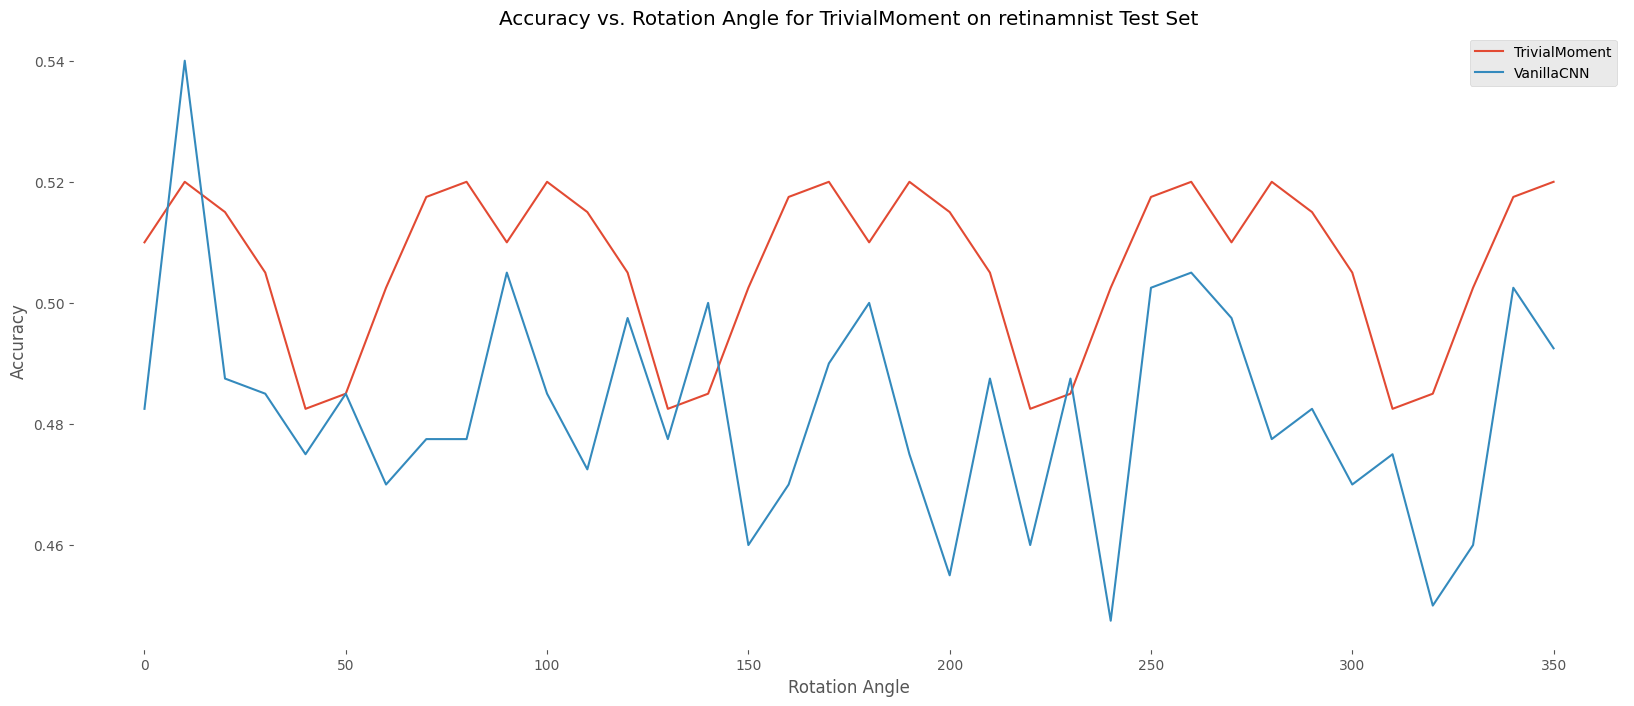

In [71]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(angles, accuracysave, label = model_name)
ax.plot(angles, accuracysave_, label = 'VanillaCNN')
ax.set_xlabel('Rotation Angle')
ax.set_ylabel('Accuracy')
ax.patch.set_facecolor('white')
ax.set_title(f"Accuracy vs. Rotation Angle for {model_name} on {data_flag} Test Set")
plt.legend()

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"{model_name}_rotation_accuracy.png"))